In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import mae

from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from cka import CudaCKA, _CKA
from collections import defaultdict
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

ds = ImageFolder(
    # "/shared/sets/datasets/vision/IN-100/val/",\
    "/home/marcin.przewiezlikowki/datasets/CUB_200_2011/images_train_test/val/",
    transform=T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(imagenet_mean, imagenet_std)
    ])
)
dl = torch.utils.data.DataLoader(ds, batch_size=5, num_workers=4)

In [3]:
n = torch.tensor([0.5, 0.3, 0.7, 0.1, 0.2])


In [4]:
torch.argsort(n), torch.argsort(torch.argsort(n)), torch.argsort(torch.argsort(torch.argsort(n)))

(tensor([3, 4, 1, 0, 2]), tensor([3, 2, 4, 0, 1]), tensor([3, 4, 1, 0, 2]))

In [5]:
cka = CudaCKA(device)

In [8]:
# vit_mae.state_dict().keys()

In [9]:
# sd = torch.load("mae_pretrain_vit_base.pth")
# sd["model"].keys()

In [10]:
vit_random =  mae.mae_vit_base_patch16().to(device)

vit_mae = mae.mae_vit_base_patch16().to(device)
vit_mae.load_state_dict(torch.load("mae_pretrain_vit_base.pth")["model"], strict=False)


_IncompatibleKeys(missing_keys=['mask_token', 'decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'decoder_blocks.2.norm1.bias', 'decoder_bl

In [12]:
# block_ratio_to_cka = defaultdict(list)
model_to_ratio_to_block_to_ckas = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

with torch.no_grad():
    for model_name, model in {"mae": vit_mae, "random": vit_random}.items():
        for (x,y) in tqdm(dl, desc=model_name):

            x = x.to(device)
            tokens, mask, ids, x_blocks = model.forward_encoder(x, 0)
            x_blocks_no_cls = x_blocks[:, :, 1:, :]

            x_blocks_ordered = x_blocks_no_cls.gather(
                dim=2, 
                index=ids.unsqueeze(0).unsqueeze(-1).repeat(
                    x_blocks_no_cls.shape[0], 1, 1, x_blocks_no_cls.shape[3]
                )
            )



            for mask_ratio in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
                _, m_mask, m_ids, m_x_blocks = model.forward_encoder(x, mask_ratio)
                m_ids_shuffle = torch.argsort(m_ids)
                x_blocks_ordered_for_m = x_blocks_ordered.gather(
                    dim=2,
                    index=m_ids_shuffle.unsqueeze(0).unsqueeze(-1).repeat(
                        x_blocks_ordered.shape[0], 1, 1, x_blocks_ordered.shape[3]
                    )
                )
                x_blocks_ordered_for_m = x_blocks_ordered_for_m[:, :, :(m_x_blocks.shape[2] - 1), :]

                x_blocks_ordered_for_m = torch.cat([x_blocks[:, :, :1, :], x_blocks_ordered_for_m], dim=2) # re-add the cls token

                n_blocks, bs, nt, ts = x_blocks_ordered_for_m.shape
                assert m_x_blocks.shape == x_blocks_ordered_for_m.shape

                for block_id in range(len(m_x_blocks)):
                    orig_tokens = x_blocks_ordered_for_m[block_id].reshape((bs*nt, ts))
                    m_tokens = m_x_blocks[block_id].reshape((bs*nt, ts))

                    model_to_ratio_to_block_to_ckas[model_name][mask_ratio][block_id].append(
                        _CKA(orig_tokens, m_tokens).item() 
                    )
                    # kernel_to_ratio_to_block_to_ckas["kernel"][mask_ratio][block_id].append(
                    #     cka.kernel_CKA(orig_tokens, m_tokens).item() 
                    # )

        # x.shape, x_blocks.shape, x_blocks_no_cls.shape, x_blocks_ordered.shape, x_blocks_ordered_for_m.shape, m_x_blocks.shape, #block_ratio_to_cka

random: 100%|███████████████████████████████| 1159/1159 [01:58<00:00,  9.79it/s]


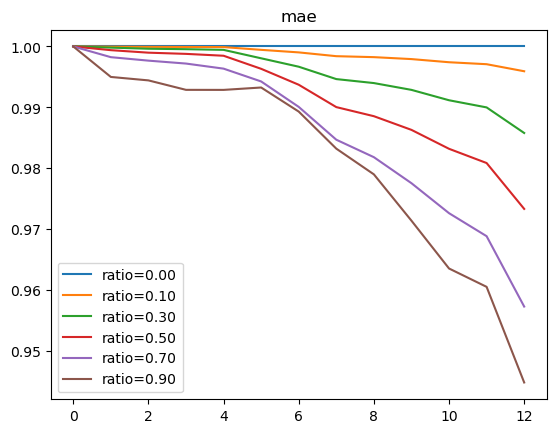

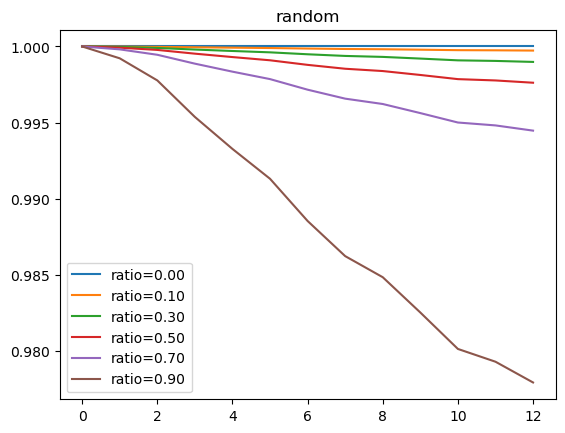

In [14]:
for model, ratio_to_block_to_ckas in model_to_ratio_to_block_to_ckas.items():
    plt.figure()
    for ratio, block_to_ckas in ratio_to_block_to_ckas.items():
        bcka_list = [np.mean(block_to_ckas[b]) for b in sorted(block_to_ckas.keys())]
        plt.plot(bcka_list, label=f"{ratio=:.2f}")
    
    plt.legend()
    plt.title(model)